# Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras import Model
import tensorflow_addons as tfa
# System libraries
from pathlib import Path
import os.path
import os
print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

TensorFlow Version 2.6.4


* Defining Classes based on different diseases of different plant species

In [ ]:
usedClass = [
 'Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Gauva__diseased',
 'Gauva__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Lemon__diseased',
 'Lemon__healthy',
 'Mango__diseased',
 'Mango__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast',
 'Soybean__bacterial_blight',
 'Soybean__caterpillar',
 'Soybean__diabrotica_speciosa',
 'Soybean__downy_mildew',
 'Soybean__healthy',
 'Soybean__mosaic_virus',
 'Soybean__powdery_mildew',
 'Soybean__rust',
 'Soybean__southern_blight',
 'Sugarcane__bacterial_blight',
 'Sugarcane__healthy',
 'Sugarcane__red_rot',
 'Sugarcane__red_stripe',
 'Sugarcane__rust',
 'Tomato__bacterial_spot',
 'Tomato__early_blight',
 'Tomato__healthy',
 'Tomato__late_blight',
 'Tomato__leaf_mold',
 'Tomato__mosaic_virus',
 'Tomato__septoria_leaf_spot',
 'Tomato__spider_mites_(two_spotted_spider_mite)',
 'Tomato__target_spot',
 'Tomato__yellow_leaf_curl_virus',
 'Wheat__brown_rust',
 'Wheat__healthy',
 'Wheat__septoria',
 'Wheat__yellow_rust']

* Defining constants

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
n_classes = len(usedClass)
EPOCHS = 5

path = '/kaggle/input/plant-disease-classification-merged-dataset'

classes = {i:j for i,j in enumerate(usedClass)}
classes

{0: 'Apple__black_rot',
 1: 'Apple__healthy',
 2: 'Apple__rust',
 3: 'Apple__scab',
 4: 'Chili__healthy',
 5: 'Chili__leaf curl',
 6: 'Chili__leaf spot',
 7: 'Chili__whitefly',
 8: 'Chili__yellowish',
 9: 'Corn__common_rust',
 10: 'Corn__gray_leaf_spot',
 11: 'Corn__healthy',
 12: 'Corn__northern_leaf_blight',
 13: 'Cucumber__diseased',
 14: 'Cucumber__healthy',
 15: 'Gauva__diseased',
 16: 'Gauva__healthy',
 17: 'Grape__black_measles',
 18: 'Grape__black_rot',
 19: 'Grape__healthy',
 20: 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 21: 'Lemon__diseased',
 22: 'Lemon__healthy',
 23: 'Mango__diseased',
 24: 'Mango__healthy',
 25: 'Pepper_bell__bacterial_spot',
 26: 'Pepper_bell__healthy',
 27: 'Potato__early_blight',
 28: 'Potato__healthy',
 29: 'Potato__late_blight',
 30: 'Rice__brown_spot',
 31: 'Rice__healthy',
 32: 'Rice__hispa',
 33: 'Rice__leaf_blast',
 34: 'Rice__neck_blast',
 35: 'Soybean__bacterial_blight',
 36: 'Soybean__caterpillar',
 37: 'Soybean__diabrotica_speciosa',
 38:

In [4]:
image_dir = Path(path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
print(image_df.Filepath[0])

/kaggle/input/plant-disease-classification-merged-dataset/Tomato__septoria_leaf_spot/8854cb53-e283-46b4-b150-3d0b414b77fd___Matt.S_CG 0951.JPG


In [5]:
labels_to_filter = usedClass
image_df = image_df[image_df['Label'].isin(labels_to_filter)]

In [6]:
image_df = image_df.reset_index()

# Train Test split

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2,stratify=image_df['Label'], random_state=42)
train_df, val_df = train_test_split(image_df, test_size=0.2,stratify=image_df['Label'], random_state=42)

In [8]:
import tensorflow as tf

# Define the augmentations for training
train_augmentations = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Normalization()
])

# Define the augmentations for validation (minimal augmentations)
val_augmentations = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Normalization()
])

# Define the augmentations for test (minimal augmentations)
test_augmentations = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Normalization()
])

# Create the training data generator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=train_augmentations,
)

# Create the validation data generator
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=val_augmentations,
)

# Create the test data generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=test_augmentations,
)

In [9]:
train_gen = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_gen = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 52840 validated image filenames belonging to 63 classes.
Found 13210 validated image filenames belonging to 63 classes.
Found 13210 validated image filenames belonging to 63 classes.


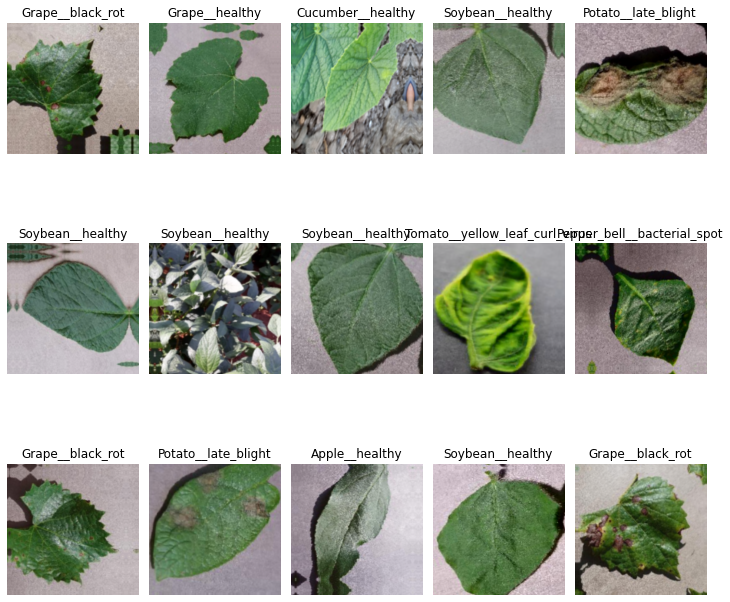

In [10]:
warnings.filterwarnings("ignore")

images = [train_gen[0][0][i] for i in range(16)]
labels = [train_gen[0][1][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img,label, ax in zip(images,labels, axes):
    ax.imshow(img)
    ax.set_title(classes[int(tf.math.argmax(label))])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model development

In [11]:
# Create checkpoint callback
checkpoint_path = "plant_disease_detection_model_checkpoint_{epoch:02d}.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [12]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 4,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [13]:
!pip install vit_keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=e89a4e3738e8cf29cf234acf71c57a7dc97c91b5b42f597cc2585b7c72c30026
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


# ViT B_16 Model (Vision Transformer)

In [14]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

347512832/347502902 [==============================] - 1s 0us/step


* Creating custom layers

In [15]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


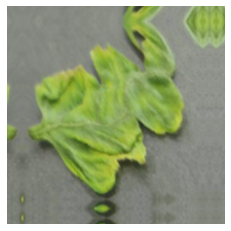

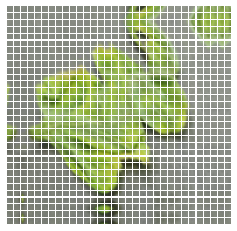

In [16]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (IMAGE_SIZE // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (IMAGE_SIZE, IMAGE_SIZE)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {IMAGE_SIZE} X {IMAGE_SIZE}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

## Model Architecture

In [17]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(len(usedClass), 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 63)         

## Model Training & Evaluation

In [18]:
warnings.filterwarnings("ignore")
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=len(usedClass))])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = val_gen.n // val_gen.batch_size

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks=[
              early_stopping,
              checkpoint_callback,
          ],
          verbose=1)

Epoch 1/5
1651/1651 [==============================] - 5367s 3s/step - loss: 1.3535 - accuracy: 0.6126 - f1_score: 0.4116 - val_loss: 1.3794 - val_accuracy: 0.6127 - val_f1_score: 0.4129
Epoch 2/5
1651/1651 [==============================] - 4747s 3s/step - loss: 0.6596 - accuracy: 0.7865 - f1_score: 0.6007 - val_loss: 0.8103 - val_accuracy: 0.7453 - val_f1_score: 0.5567
Epoch 3/5
1651/1651 [==============================] - 4771s 3s/step - loss: 0.5279 - accuracy: 0.8278 - f1_score: 0.6616 - val_loss: 0.5841 - val_accuracy: 0.8122 - val_f1_score: 0.6271
Epoch 4/5
1651/1651 [==============================] - 4838s 3s/step - loss: 0.4688 - accuracy: 0.8455 - f1_score: 0.6850 - val_loss: 0.6380 - val_accuracy: 0.8041 - val_f1_score: 0.6390
Epoch 5/5
1651/1651 [==============================] - 4771s 3s/step - loss: 0.4149 - accuracy: 0.8614 - f1_score: 0.7192 - val_loss: 0.4412 - val_accuracy: 0.8582 - val_f1_score: 0.7022


In [19]:
# Save The Model
model.save('plant_diseases_detection_final_model.keras')

In [20]:
!pip freeze > requirements.txt

In [21]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/plant_diseases_detection_final_model.keras')

/kaggle/working/plant_diseases_detection_final_model.keras

## Evaluating model performance on test dataset

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       124
           1       0.90      0.95      0.93       330
           2       0.88      0.62      0.73        71
           3       0.97      0.82      0.89       140
           4       0.70      0.35      0.47        20
           5       0.00      0.00      0.00        20
           6       0.29      0.10      0.15        20
           7       1.00      0.05      0.10        20
           8       0.70      0.35      0.47        20
           9       0.98      0.92      0.95       262
          10       0.85      0.63      0.72       219
          11       1.00      0.96      0.98       232
          12       0.60      0.87      0.71       245
          13       0.84      0.89      0.86        70
          14       0.86      0.84      0.85        68
          15       0.82      0.82      0.82        28
          16       0.91      0.56      0.70        55
          17       0.90    

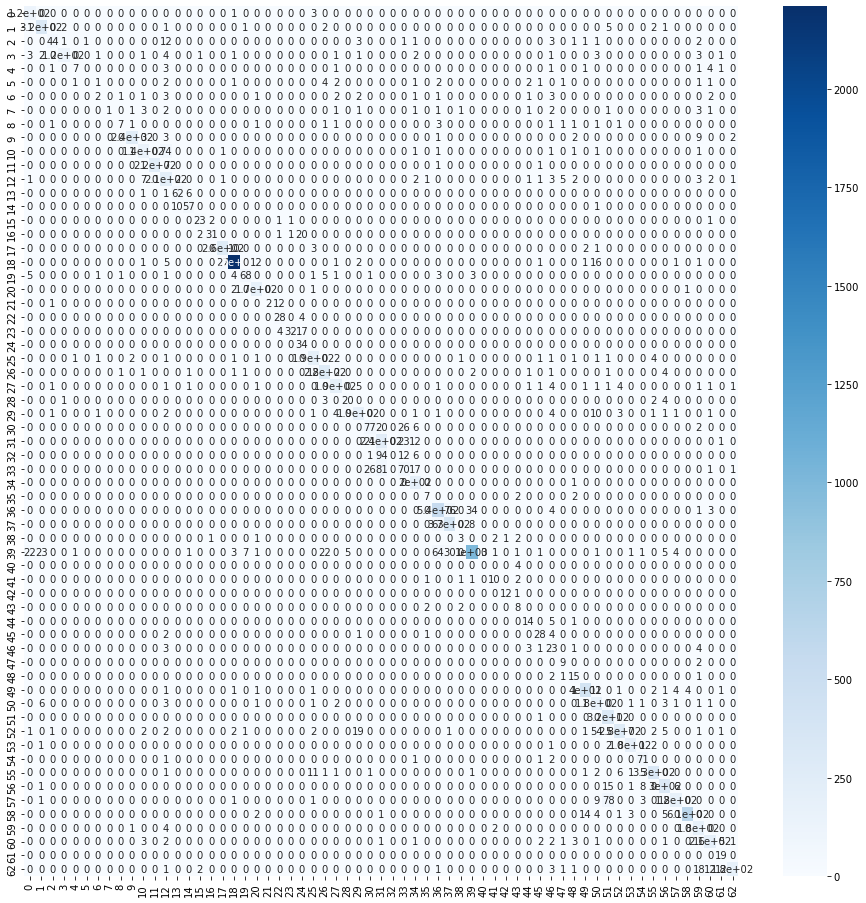

In [22]:
predicted_classes = np.argmax(model.predict(test_gen, steps = test_gen.n // test_gen.batch_size + 1), axis = 1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))